In [38]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import gaussian_kde as GKDE

from scipy.stats import norm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import random

import matplotlib.patches as patches

import seaborn as sns

from mpl_toolkits import mplot3d
import matplotlib as mpl

import src.weightedEDFs as wEDFs
import src.distributionsDCI as distDCI
import src.utils as utils

In [39]:
plot_directory = './plots'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 
plt.rcParams['image.cmap'] = 'viridis'

In [40]:
random.seed(20)
np.random.seed(66)

In [42]:
start_data = np.genfromtxt('./data/streams-initial-start.dat',
                           dtype=[('float'),('float'),('float')])
init_samples_full = []
for i in start_data:
    init_samples_full.append([i[0], i[1], i[2]])
init_samples_full = np.array(init_samples_full)

In [43]:
finish_data = np.genfromtxt('./data/streams-initial-finish.dat',
                            dtype=[('float'),('float'),('float')])
pred_samples_full = []
for i in finish_data:
    pred_samples_full.append([i[0], i[1], i[2]])
pred_samples_full = np.array(pred_samples_full)

In [44]:
# extract finish points that are within 100 ft of the end of the domain
pred_samples = pred_samples_full[pred_samples_full[:,1] < 100, :1]
init_samples = init_samples_full[pred_samples_full[:,1] < 100, :]
n_init_samples = len(init_samples)

In [45]:
n_obs_samples = 10000

obs_dist = norm(900, 25)

obs_samples = obs_dist.rvs((n_obs_samples,1))

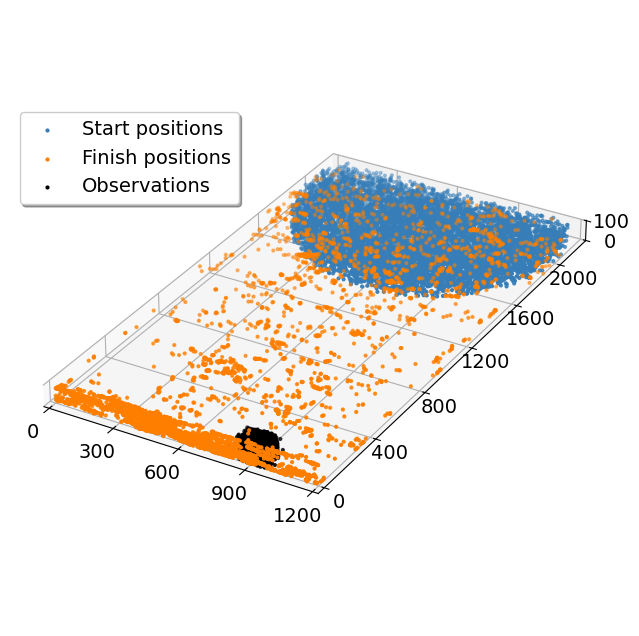

In [46]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(init_samples_full[:,0], init_samples_full[:,1], init_samples_full[:,2],
           label='Start positions', s=4)
ax.scatter(pred_samples_full[:,0], pred_samples_full[:,1], pred_samples_full[:,2],
           label='Finish positions', s=4)
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Observations', s=4)

ax.set_ylim(0, 2200)
ax.set_xlim(0, 1200)
ax.set_zlim(0, 100)
ax.set_xticks([0,300,600,900,1200])
ax.set_xticklabels([0,300,600,900,1200])
ax.set_yticks([0,400,800,1200,1600,2000])
ax.set_yticklabels([0,400,800,1200,1600,2000])
ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), shadow=True)
ax.set_zticks([0,100])
ax.set_zticklabels([0,100])
ax.set_box_aspect([1.0, 1.83, 0.08])

plt.savefig(f'{plot_directory}/fluid-flow_start_end.png', bbox_inches='tight')

In [12]:
pred_KDE = GKDE(pred_samples.T)
obs_KDE = GKDE(obs_samples.T)
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
PF_update_KDE = GKDE(pred_samples.T, weights=rn_w)

print(np.mean(r))

1.0788294083924828


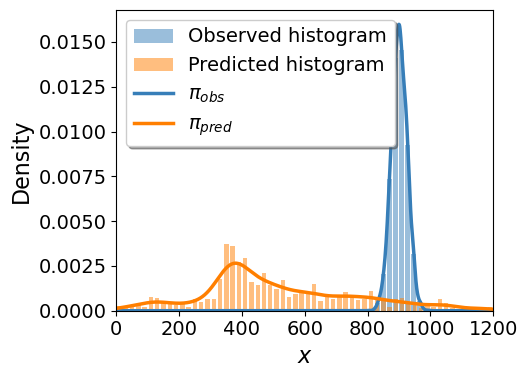

In [15]:
plt.hist(obs_samples, bins=10, density=True, label='Observed histogram', alpha=0.5, rwidth=0.8);
plt.hist(pred_samples, bins=60, density=True, label='Predicted histogram', alpha=0.5, rwidth=0.7);
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000);
plt.plot(xx, obs_KDE.pdf(xx), label=r'$\pi_{obs}$', c=CB_color_cycle[0]);
plt.plot(xx, pred_KDE.pdf(xx), label=r'$\pi_{pred}$', c=CB_color_cycle[1]);
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.0f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)]);
plt.xlim(np.min(xx), np.max(xx))
plt.xlabel(r'$x$');
plt.ylabel('Density');
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/fluid-flow_samples.png', bbox_inches='tight')

In [17]:
pred_KDE = GKDE(pred_samples.T)
obs_KDE = GKDE(obs_samples.T)
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
PF_update_KDE = GKDE(pred_samples.T, weights=rn_w)

print(np.mean(r))

1.0788294083924828


In [19]:
n_clusters = 120
w, labels, centers, w_cluster = distDCI.computePartitionedWeights_kMeans_IID(init_samples,
                                                                             pred_samples,
                                                                             sample_set_2=obs_samples,
                                                                             n_clusters=n_clusters)

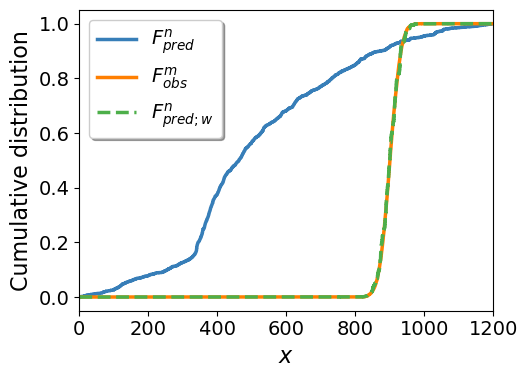

In [21]:
isort = np.argsort(pred_samples[:,0])
isort_obs = np.argsort(obs_samples[:,0])

plt.step(pred_samples[isort], np.cumsum([1/n_init_samples]*n_init_samples),
         label=r'$F^n_{pred}$')
plt.step(np.append(0, np.append(obs_samples[isort_obs], [np.max(pred_samples)])),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), [1])),
         label=r'$F^m_{obs}$')
plt.step(pred_samples[isort], np.cumsum(w[isort]),
         label=r'$F^n_{pred;w}$', ls='dashed')
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);
plt.xlim(0,1200)

plt.xlabel(r'$x$')
plt.ylabel('Cumulative distribution')
plt.legend(loc='upper left', shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/fluid_flow_kmeans_cdfs.png', bbox_inches='tight')

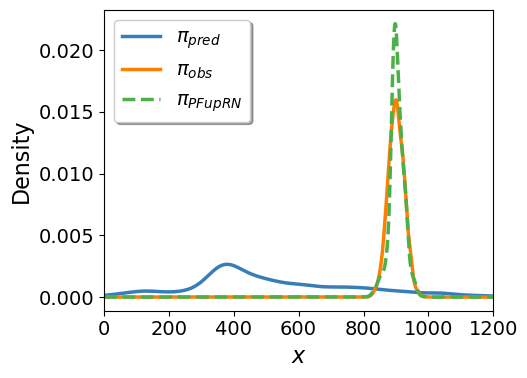

In [22]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$')
plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$')
plt.plot(xx, PF_update_KDE(xx), label=r'$\pi_{PFupRN}$', ls='--')
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);
plt.xlim(0,1200);

plt.xlabel(r'$x$')
plt.ylabel('Density')
plt.legend(loc='upper left', shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/fluid_flow_kmeans_pdfs.png', bbox_inches='tight')

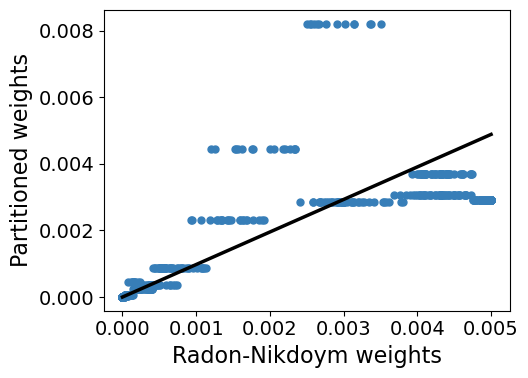

In [24]:
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikdoym weights')
plt.ylabel('Partitioned weights')
plt.scatter(rn_w, w, label='K-Means partitioning')
plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(w), np.max(rn_w), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/fluid_flow_kmeans_weights.png', bbox_inches='tight')

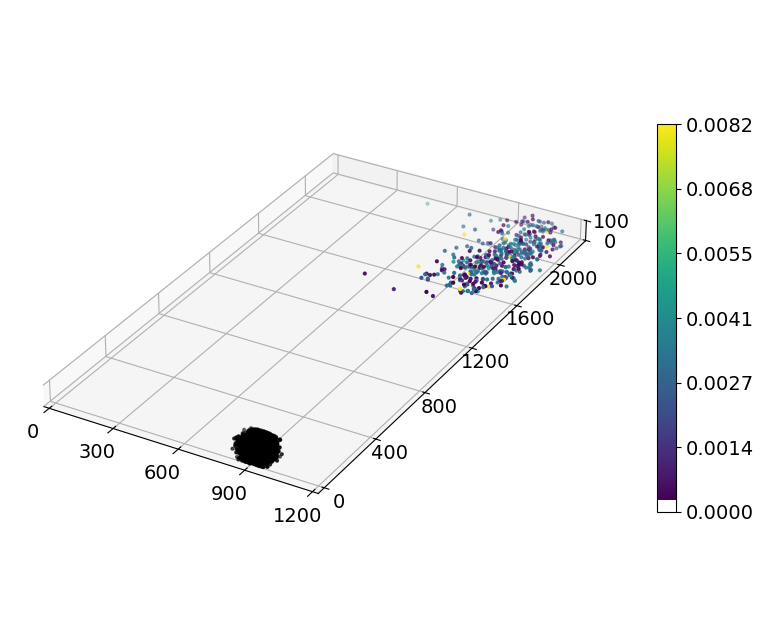

In [25]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')

tolerance = 0.0001

p = ax.scatter(init_samples[w > tolerance,0], init_samples[w > tolerance,1], init_samples[w>tolerance,2],
               c=w[w > tolerance], label='Start positions', s=4)
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Finish positions', s=4)

ax.set_ylim(0, 2200)
ax.set_xlim(0, 1200)
ax.set_zlim(0, 100)
ax.set_xticks([0,300,600,900,1200])
ax.set_xticklabels([0,300,600,900,1200])
ax.set_yticks([0,400,800,1200,1600,2000])
ax.set_yticklabels([0,400,800,1200,1600,2000])
ax.set_zticks([0,100])
ax.set_zticklabels([0,100])

cbar = fig.colorbar(p, ax=ax, fraction=0.025, pad=0.04)
cbar.set_ticks(np.linspace(np.min(w), np.max(w), 7));
cbar.ax.set_yticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w), np.max(w), 7)]);

ax.set_box_aspect([1.0, 1.83, 0.08])

plt.savefig(f'{plot_directory}/fluid_flow_kmeans_res.png', bbox_inches='tight')

In [26]:
update_inds = utils.rejection_sampling(rn_w)

update_samples = init_samples[update_inds]
n_update_samples = len(update_samples)

pf_samples = pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

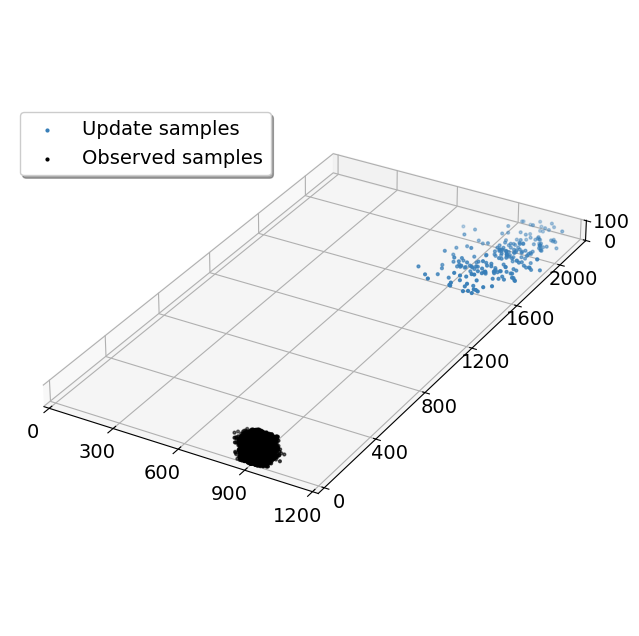

In [27]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')

ax.scatter(update_samples[:,0], update_samples[:,1], update_samples[:,2], s=4, label='Update samples')
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Observed samples', s=4)

ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), shadow=True)

ax.set_ylim(0, 2200)
ax.set_xlim(0, 1200)
ax.set_zlim(0, 100)
ax.set_xticks([0,300,600,900,1200])
ax.set_xticklabels([0,300,600,900,1200])
ax.set_yticks([0,400,800,1200,1600,2000])
ax.set_yticklabels([0,400,800,1200,1600,2000])
ax.set_zticks([0,100])
ax.set_zticklabels([0,100])

ax.set_box_aspect([1.0, 1.83, 0.08])

plt.savefig(f'/Users/kirana/Desktop/work/paper/fluid_flow_density_res_rej.png', bbox_inches='tight')

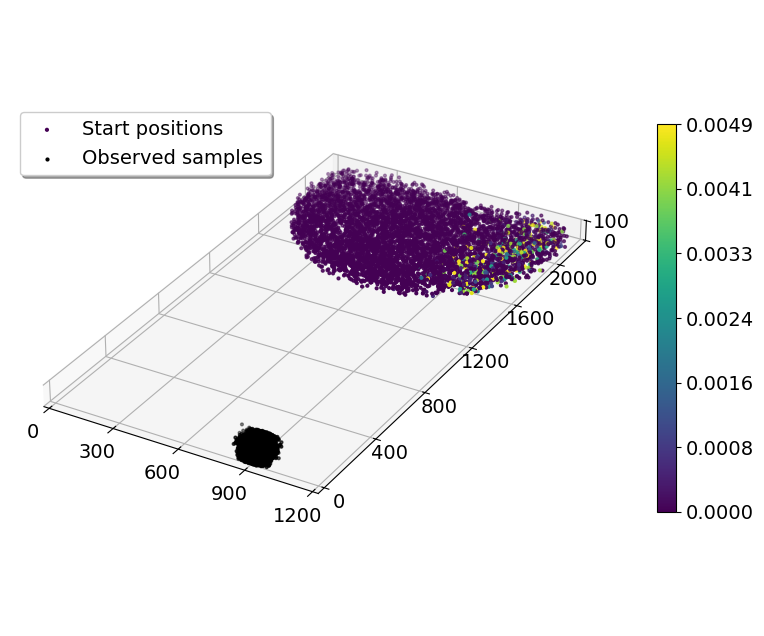

In [29]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')

p = ax.scatter(init_samples[:,0], init_samples[:,1], init_samples[:,2],
               c=rn_w, label='Start positions', s=4)
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Observed samples', s=4)

ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), shadow=True)

ax.set_ylim(0, 2200)
ax.set_xlim(0, 1200)
ax.set_zlim(0, 100)
ax.set_xticks([0,300,600,900,1200])
ax.set_xticklabels([0,300,600,900,1200])
ax.set_yticks([0,400,800,1200,1600,2000])
ax.set_yticklabels([0,400,800,1200,1600,2000])
ax.set_zticks([0,100])
ax.set_zticklabels([0,100])

cbar = fig.colorbar(p, ax=ax, fraction=0.025, pad=0.04)
cbar.set_ticks(np.linspace(np.min(rn_w), np.max(rn_w), 7));
cbar.ax.set_yticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 7)]);

ax.set_box_aspect([1.0, 1.83, 0.08])

plt.savefig(f'{plot_directory}/fluid_flow_density_res.png', bbox_inches='tight')

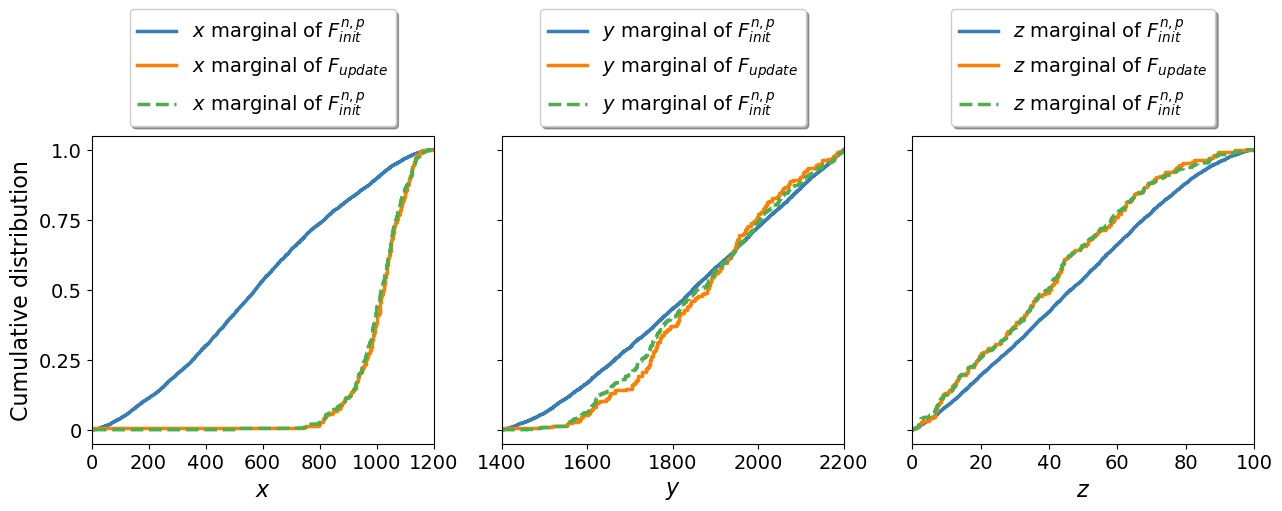

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,4))

# x -------------------------------------------
isort = np.argsort(init_samples[:,0])
isort_up = np.argsort(update_samples[:,0])

ax1.step(init_samples[isort,0], np.cumsum([1/n_init_samples]*n_init_samples),
         label='$x$ marginal of $F^{n,p}_{init}$');
ax1.step(np.append(0, np.append(update_samples[isort_up,0], [np.max(init_samples[:,0])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$x$ marginal of $F_{update}$');
ax1.step(init_samples[isort,0], np.cumsum(w[isort]),
         label='$x$ marginal of $F^{n,p}_{init}$', ls='dashed');
ax1.set_xticks([0,200,400,600,800,1000,1200]);
ax1.set_xticklabels([0,200,400,600,800,1000,1200]);
ax1.set_xlim(0,1200);
ax1.set_yticks([0,0.25, 0.5, 0.75, 1.0]);
ax1.set_yticklabels([0,0.25, 0.5, 0.75, 1.0]);

ax1.set_xlabel('$x$');
ax1.set_ylabel('Cumulative distribution');

ax1.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

# y -----------------------------------
isort = np.argsort(init_samples[:,1])
isort_up = np.argsort(update_samples[:,1])

ax2.step(np.append(1400, init_samples[isort,1]), np.append(0,np.cumsum([1/n_init_samples]*n_init_samples)),
         label='$y$ marginal of $F^{n,p}_{init}$')
ax2.step(np.append([1400], np.append(update_samples[isort_up,1], [np.max(init_samples[:,1])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$y$ marginal of $F_{update}$')
ax2.step(np.append(1400, init_samples[isort,1]), np.append(0, np.cumsum(w[isort])),
         label='$y$ marginal of $F^{n,p}_{init}$', ls='dashed')
ax2.set_xticks([1400,1600,1800,2000,2200]);
ax2.set_xticklabels(labels=[1400,1600,1800,2000,2200]);
ax2.set_xlim(1400,2200)

ax2.set_xlabel('$y$');

ax2.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

# z -----------------------------------
isort = np.argsort(init_samples[:,2])
isort_up = np.argsort(update_samples[:,2])

ax3.step(init_samples[isort,2], np.cumsum([1/n_init_samples]*n_init_samples),
         label='$z$ marginal of $F^{n,p}_{init}$')
ax3.step(np.append([np.min(init_samples[:,2])], np.append(update_samples[isort_up,2], [np.max(init_samples[:,2])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$z$ marginal of $F_{update}$')
ax3.step(init_samples[isort,2], np.cumsum(w[isort]),
         label='$z$ marginal of $F^{n,p}_{init}$', ls='dashed')

ax3.set_xticks([0,20,40,60,80,100]);
ax3.set_xticklabels(labels=[0,20,40,60,80,100]);
ax3.set_xlim(0,100)
ax3.set_xlabel('$z$');

ax3.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

plt.savefig(f'/Users/kirana/Desktop/work/paper/fluid_flow_kmeans_marginals.png', bbox_inches='tight')

In [22]:
n_bins = [120]
w, labels, centers, w_cluster = weights.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                                  pred_samples,
                                                                                  sample_set_2=obs_samples,
                                                                                  n_bins=n_bins,
                                                                                  remove_empty_bins=True)

     pcost       dcost       gap    pres   dres
 0: -5.0310e-02 -1.2019e+02  1e+02  2e-16  2e+01
 1: -5.0485e-02 -1.3906e+00  1e+00  2e-15  2e-01
 2: -6.2639e-02 -1.8992e-01  1e-01  2e-15  2e-02
 3: -1.0824e-01 -1.7670e-01  7e-02  4e-15  9e-18
 4: -1.1429e-01 -1.2379e-01  1e-02  3e-15  5e-18
 5: -1.1723e-01 -1.1937e-01  2e-03  7e-15  3e-18
 6: -1.1784e-01 -1.1829e-01  5e-04  7e-15  3e-18
 7: -1.1798e-01 -1.1808e-01  9e-05  7e-15  3e-18
 8: -1.1801e-01 -1.1803e-01  2e-05  9e-15  4e-18
 9: -1.1802e-01 -1.1802e-01  4e-06  3e-15  3e-18
10: -1.1802e-01 -1.1802e-01  8e-07  7e-15  5e-18
11: -1.1802e-01 -1.1802e-01  2e-07  1e-14  4e-18
12: -1.1802e-01 -1.1802e-01  3e-08  6e-15  4e-18
Optimal solution found.


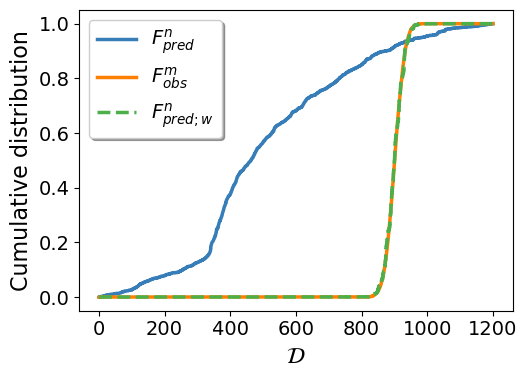

In [32]:
isort = np.argsort(pred_samples[:,0])
isort_obs = np.argsort(obs_samples[:,0])

plt.step(pred_samples[isort], np.cumsum([1/n_init_samples]*n_init_samples),
         label=r'$F^n_{pred}$')
plt.step(np.append(0, np.append(obs_samples[isort_obs], [np.max(pred_samples)])),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), [1])),
         label=r'$F^m_{obs}$')
plt.step(pred_samples[isort], np.cumsum(w[isort]),
         label=r'$F^n_{pred;w}$', ls='dashed')
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);

plt.xlabel(r'$\mathcal{D}$')
plt.ylabel('Cumulative distribution')
plt.legend(loc='upper left', shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/fluid_flow_rgrid_cdfs.png', bbox_inches='tight')

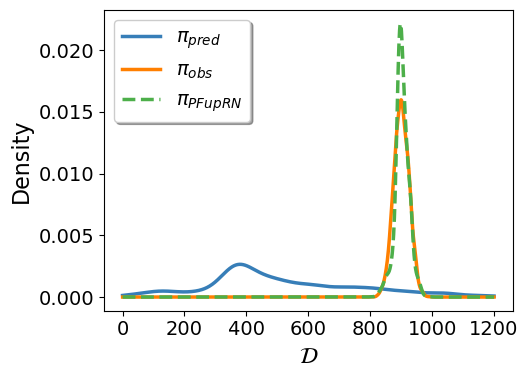

In [34]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$')
plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$')
plt.plot(xx, PF_update_KDE(xx), label=r'$\pi_{PFupRN}$', ls='--')
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);

plt.xlabel(r'$\mathcal{D}$')
plt.ylabel('Density')
plt.legend(loc='upper left', shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/fluid_flow_rgrid_pdfs.png', bbox_inches='tight')

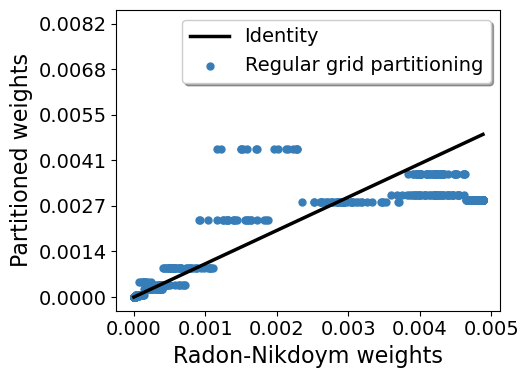

In [35]:
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikdoym weights')
plt.ylabel('Partitioned weights')
plt.scatter(rn_w, w, label='Regular grid partitioning')
plt.yticks(ticks=np.linspace(np.min(w), np.max(w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(w), np.max(w), 7)])
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/fluid_flow_rgrid_weights.png', bbox_inches='tight')

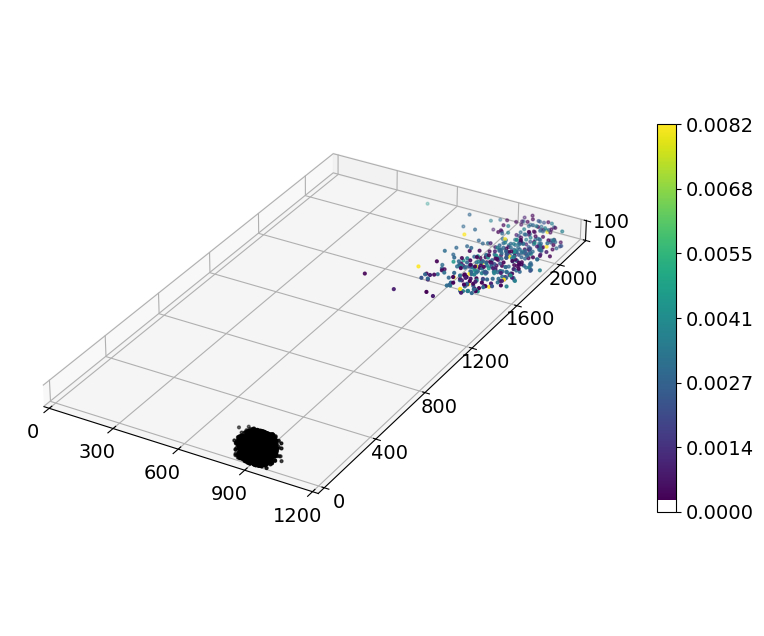

In [36]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')

tolerance = 0.0001
p = ax.scatter(init_samples[w > tolerance,0], init_samples[w > tolerance,1], init_samples[w>tolerance,2],
               c=w[w > tolerance], label='Start positions', s=4)

ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Finish positions', s=4)

ax.set_ylim(0, 2200)
ax.set_xlim(0, 1200)
ax.set_zlim(0, 100)
ax.set_xticks([0,300,600,900,1200])
ax.set_xticklabels([0,300,600,900,1200])
ax.set_yticks([0,400,800,1200,1600,2000])
ax.set_yticklabels([0,400,800,1200,1600,2000])
ax.set_zticks([0,100])
ax.set_zticklabels([0,100])

cbar = fig.colorbar(p, ax=ax, fraction=0.025, pad=0.04)
cbar.set_ticks(np.linspace(np.min(w), np.max(w), 7));
cbar.ax.set_yticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w), np.max(w), 7)]);

ax.set_box_aspect([1.0, 1.83, 0.08])
plt.savefig(f'{plot_directory}/fluid_flow_rgrid_res.png', bbox_inches='tight')

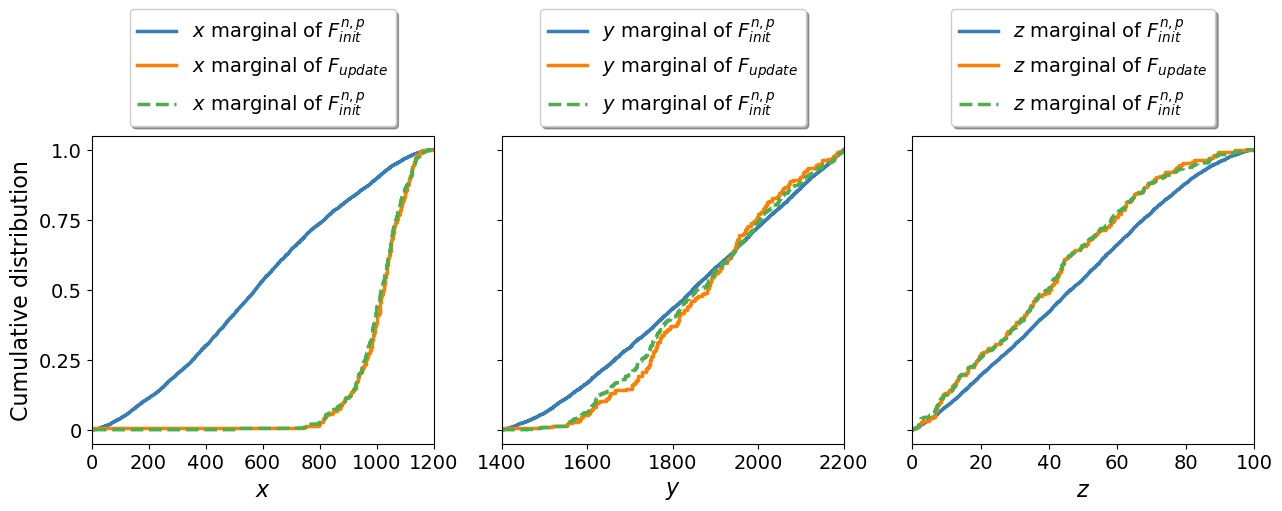

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,4))

# x -------------------------------------------
isort = np.argsort(init_samples[:,0])
isort_up = np.argsort(update_samples[:,0])

ax1.step(init_samples[isort,0], np.cumsum([1/n_init_samples]*n_init_samples),
         label=r'$x$ marginal of $F^{n,p}_{init}$');
ax1.step(np.append(0, np.append(update_samples[isort_up,0], [np.max(init_samples[:,0])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label=r'$x$ marginal of $F_{update}$');
ax1.step(init_samples[isort,0], np.cumsum(w[isort]),
         label=r'$x$ marginal of $F^{n,p}_{init}$', ls='dashed');

ax1.set_xticks([0,200,400,600,800,1000,1200]);
ax1.set_xticklabels([0,200,400,600,800,1000,1200]);
ax1.set_xlim(0,1200);
ax1.set_yticks([0,0.25, 0.5, 0.75, 1.0]);
ax1.set_yticklabels([0,0.25, 0.5, 0.75, 1.0]);

ax1.set_xlabel(r'$x$');
ax1.set_ylabel('Cumulative distribution');

ax1.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

# y -----------------------------------
isort = np.argsort(init_samples[:,1])
isort_up = np.argsort(update_samples[:,1])

ax2.step(np.append(1400, init_samples[isort,1]), np.append(0,np.cumsum([1/n_init_samples]*n_init_samples)),
         label=r'$y$ marginal of $F^{n,p}_{init}$')
ax2.step(np.append([1400], np.append(update_samples[isort_up,1], [np.max(init_samples[:,1])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label=r'$y$ marginal of $F_{update}$')
ax2.step(np.append(1400, init_samples[isort,1]), np.append(0, np.cumsum(w[isort])),
         label=r'$y$ marginal of $F^{n,p}_{init}$', ls='dashed')

ax2.set_xticks([1400,1600,1800,2000,2200]);
ax2.set_xticklabels(labels=[1400,1600,1800,2000,2200]);
ax2.set_xlim(1400,2200)
ax2.set_xlabel(r'$y$');

ax2.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

# z -----------------------------------
isort = np.argsort(init_samples[:,2])
isort_up = np.argsort(update_samples[:,2])

ax3.step(init_samples[isort,2], np.cumsum([1/n_init_samples]*n_init_samples),
         label=r'$z$ marginal of $F^{n,p}_{init}$')
ax3.step(np.append([np.min(init_samples[:,2])], np.append(update_samples[isort_up,2], [np.max(init_samples[:,2])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label=r'$z$ marginal of $F_{update}$')
ax3.step(init_samples[isort,2], np.cumsum(w[isort]),
         label=r'$z$ marginal of $F^{n,p}_{init}$', ls='dashed')
ax3.set_xticks([0,20,40,60,80,100]);
ax3.set_xticklabels(labels=[0,20,40,60,80,100]);
ax3.set_xlim(0,100)
ax3.set_xlabel(r'$z$');

ax3.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

plt.savefig(f'{plot_directory}/fluid_flow_rgrid_marginals.png', bbox_inches='tight')